In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing

In [3]:
# Load data
df = pd.read_pickle("./GTZAN/rawFeaturesGTZAN.pkl")

# Split into train and test
data = df.drop(["path", "class"], axis=1)

X = data.to_numpy()
y = df["class"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)

# Get validation set to test parameters for traditional methods on it
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=True, stratify=y_train)

Scaling features to standard Gauss distribution (mean=0, variance=1)

In [4]:
gaussScaler = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train_scaled = gaussScaler.transform(X_train)

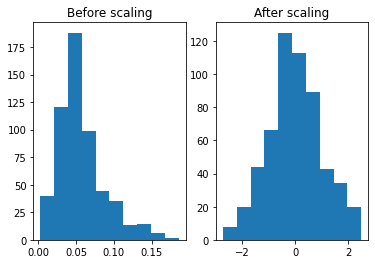

In [5]:
plt.subplot(1,2,1)
plt.hist(X_train[:,1])
plt.title("Before scaling")
plt.subplot(1,2,2)
plt.hist(X_train_scaled[:,1])
plt.title("After scaling")
plt.show()

In [6]:
y_trainExpanded = np.expand_dims(y_train, axis=1)
trainDataMat = np.concatenate((X_train_scaled, y_trainExpanded), axis=1)

In [7]:
headers = list(data)+["class"]
trainData = pd.DataFrame(data=trainDataMat, columns=headers)
trainData.to_csv("./GTZAN/trainGTZAN.csv", index=False)

Getting subset of most important features

In [8]:
featureImportance = []
with open("featureImportance.csv") as handle:
    for line in handle:
        temp = line.rstrip().split(";")
        featureImportance.append([temp[0], float(temp[1])])
score = np.array([float(x[1]) for x in featureImportance])

THRESHOLD = np.mean(score)
print("Current threshold",THRESHOLD)
overThreshold = [x for x in featureImportance if x[1]>=THRESHOLD]
overThresholdLabels = [x[0].rstrip().replace(".","-") for x in overThreshold]
print("Features over threshold",overThresholdLabels)

Current threshold 0.03784272953195986
Features over threshold ['spectral-contrast7-mean', 'spectral-contrast5-mean', 'spectral-bandwith-mean', 'spectral-rolloff-mean', 'zero-cross-rate-std', 'spectral-contrast4-mean', 'rmse-mean', 'spectral-centroid-std', 'spectral-centroid-mean', 'rmse-std', 'spectral-rolloff-std', 'spectral-contrast3-mean', 'mfcc1-mean', 'zero-cross-rate-mean', 'mfcc4-mean', 'spectral-contrast5-std', 'mfcc7-std', 'spectral-bandwith-std', 'spectral-contrast3-std', 'mfcc2-mean', 'chroma7-mean', 'mfcc4-std', 'mfcc9-mean', 'spectral-contrast4-std', 'mfcc6-mean', 'mfcc5-std', 'mfcc7-mean', 'mfcc13-mean', 'mfcc6-std', 'spectral-contrast2-std', 'mfcc10-mean', 'mfcc3-mean', 'chroma5-mean', 'mfcc12-mean', 'mfcc8-mean', 'spectral-contrast6-mean', 'chroma6-mean', 'mfcc20-std']


In [9]:
def evalRandomForest(X_train, X_test, y_train, n=100):
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    model = rf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

In [10]:
featureSorted = [x[0] for x in featureImportance]

currentFeatures = []
bestF1 = None
bestFeatureSet = None

for feature in featureSorted:
    currentFeatures.append(feature)
    currData = data[currentFeatures]
    currX = currData.to_numpy()
    currY = df["class"].to_numpy()
    
    currX_train, currX_test, currY_train, currY_test = train_test_split(currX, currY, test_size=0.25, random_state=42, shuffle=True, stratify=currY)
    # Get validation set to test parameters for traditional methods on it
    currX_train, currX_val, currY_train, currY_val = train_test_split(currX_train, currY_train, test_size=0.25, random_state=42, shuffle=True, stratify=currY_train)

    currY_pred = evalRandomForest(currX_train, currX_val, currY_train)
    currF1 = f1_score(currY_val, currY_pred, average='macro')
    
    if bestF1 == None:
        bestF1 = currF1
        bestFeatureSet = currentFeatures[:]
    elif currF1 > bestF1:
        bestF1 = currF1
        bestFeatureSet = currentFeatures[:]

    
print("Best F1", bestF1)
print("Best subset", bestFeatureSet)
print("Length of features in subset", len(bestFeatureSet))

Best F1 0.6568694014586185
Best subset ['spectral-contrast7-mean', 'spectral-contrast5-mean', 'spectral-bandwith-mean', 'spectral-rolloff-mean', 'zero-cross-rate-std', 'spectral-contrast4-mean', 'rmse-mean', 'spectral-centroid-std', 'spectral-centroid-mean', 'rmse-std', 'spectral-rolloff-std', 'spectral-contrast3-mean', 'mfcc1-mean', 'zero-cross-rate-mean', 'mfcc4-mean', 'spectral-contrast5-std', 'mfcc7-std', 'spectral-bandwith-std', 'spectral-contrast3-std', 'mfcc2-mean', 'chroma7-mean', 'mfcc4-std', 'mfcc9-mean', 'spectral-contrast4-std', 'mfcc6-mean', 'mfcc5-std', 'mfcc7-mean', 'mfcc13-mean', 'mfcc6-std', 'spectral-contrast2-std', 'mfcc10-mean', 'mfcc3-mean', 'chroma5-mean', 'mfcc12-mean', 'mfcc8-mean', 'spectral-contrast6-mean', 'chroma6-mean', 'mfcc20-std', 'mfcc17-mean', 'chroma4-mean', 'chroma9-mean', 'mfcc5-mean', 'mfcc15-mean', 'chroma8-mean', 'chroma12-mean', 'mfcc19-std', 'chroma2-mean', 'chroma1-std', 'mfcc13-std', 'mfcc2-std', 'spectral-contrast2-mean', 'mfcc8-std', 'chrom